<a href="https://colab.research.google.com/github/fathiimarisha/AI-Assisted-Laryngoscope/blob/main/Testing/Tiny_U_Net_Test_SUBSET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files extracted to: /content/training
Example files: ['training']
Loaded 300 images from /content/training
Using device: cuda
Epoch 1/2, Loss: 0.5137
Epoch 2/2, Loss: 0.5664


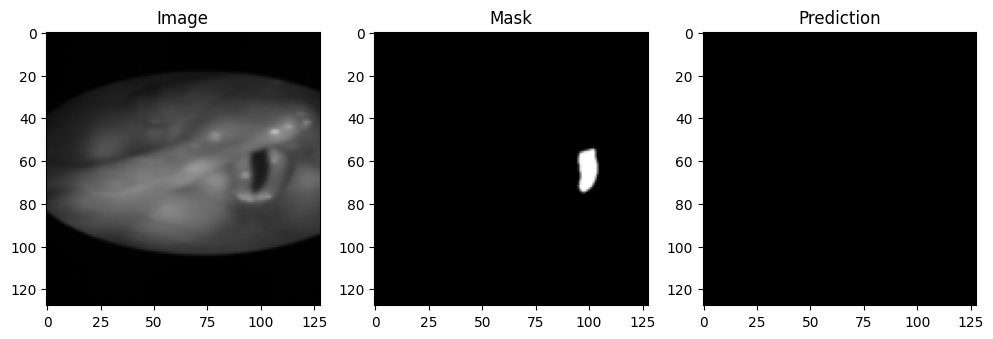

In [3]:
# ============================
# 1. Setup
# ============================
from google.colab import drive
drive.mount('/content/drive')

import zipfile, os, glob
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ============================
# 2. Extract Dataset
# ============================
zip_path = "/content/drive/MyDrive/BAGLS/training.zip"   # <-- adjust path
extract_path = "/content/training"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)
print("Example files:", os.listdir(extract_path)[:10])

# ============================
# 3. Dataset Class (Recursive)
# ============================
class BAGLSDataset(Dataset):
    def __init__(self, image_dir, mask_suffix="_seg.png", transform=None, subset_size=None):
        # Recursively find all .png files
        self.images = sorted(glob.glob(os.path.join(image_dir, "**", "*.png"), recursive=True))
        self.images = [img for img in self.images if "_seg" not in img]

        if subset_size is not None:
            self.images = self.images[:subset_size]  # Take only a small subset for quick demo

        self.masks = [img.replace(".png", mask_suffix) for img in self.images]
        self.transform = transform

        print(f"Loaded {len(self.images)} images from {image_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

# ============================
# 4. Transform + Dataset
# ============================
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# Use subset_size=300 for quick demo
train_dataset = BAGLSDataset(extract_path, transform=transform, subset_size=300)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# ============================
# 5. Tiny U-Net Model
# ============================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super(TinyUNet, self).__init__()
        self.dconv_down1 = DoubleConv(in_ch, 32)
        self.dconv_down2 = DoubleConv(32, 64)
        self.dconv_down3 = DoubleConv(64, 128)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.ConvTranspose2d(128, 64, 2, stride=2)

        self.dconv_up2 = DoubleConv(128, 64)
        self.dconv_up1 = DoubleConv(64 + 32, 32)

        self.conv_last = nn.Conv2d(32, out_ch, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        x = self.dconv_down3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=True)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return torch.sigmoid(out)

# ============================
# 6. Training
# ============================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = TinyUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

epochs = 2  # For demo

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# ============================
# 7. Test Visualization
# ============================
model.eval()
with torch.no_grad():
    images, masks = next(iter(train_loader))
    images, masks = images.to(device), masks.to(device)
    preds = model(images)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(images[0].permute(1,2,0).cpu())
    plt.subplot(1,3,2)
    plt.title("Mask")
    plt.imshow(masks[0][0].cpu(), cmap="gray")
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(preds[0][0].cpu(), cmap="gray")
    plt.show()
